# 👂 Detección De Anomalías Acústicas Con Autoencoders

## 🧩 1. Introducción
Este notebook forma parte del desarrollo del sistema EscoitaTECH, una solución de bajo coste basada en inteligencia artificial para la detección automática de fallos en máquinas industriales a través del análisis de su sonido. En concreto, se entrenará un modelo capaz de aprender el comportamiento acústico normal de una máquina, con el objetivo de identificar posibles anomalías en su funcionamiento futuro.


## 📦 2. Carga de librerías y configuración

In [21]:
import glob
import random
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve


from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import pandas as pd



## 🔊 3. Preprocesamiento De Audio 

Esta sección define el pipeline encargado de transformar los archivos de audio del dataset en espectrogramas listos para ser utilizados por el modelo. El objetivo principal es generar representaciones acústicas limpias, consistentes y robustas que permitan detectar fallos en máquinas industriales. El proceso se compone de varias etapas:

1. **Carga de archivos**: Se localizan y recopilan los archivos `.wav` correspondientes a las máquinas y tipos de grabación requeridos (por ejemplo, registros normales o anómalos), recorriendo la estructura de carpetas del dataset.

2. **Segmentación y eliminación de silencio**: Cada audio completo se divide en fragmentos más pequeños de duración fija (por ejemplo, 5 segundos) mediante una ventana deslizante. Los fragmentos con energía media inferior a un umbral definido se descartan por considerarse silenciosos y poco informativos.

3. **Pre-énfasis**: A cada segmento se le aplica un filtro de pre-énfasis, que amplifica las frecuencias más altas del sonido. Este paso es útil porque muchos fallos mecánicos se manifiestan como cambios en las frecuencias agudas, como vibraciones o fricción.

4. **Aumentación de datos**: Para enriquecer el conjunto de entrenamiento y mejorar la generalización, se genera una versión modificada de cada segmento. Solo se aplica una transformación aleatoria entre las siguientes:
   - Desplazamiento de tono (pitch shift),
   - Cambio de velocidad (time stretch),
   - Adición de ruido blanco leve.

5. **Conversión a espectrograma de Mel**: Cada segmento se transforma en un espectrograma de Mel, que representa visualmente cómo varía la energía del sonido en distintas frecuencias a lo largo del tiempo. El rango de frecuencias (`fmax`) se adapta automáticamente al tipo de micrófono utilizado por la máquina (por ejemplo, 2000 Hz para micrófonos de contacto).

6. **Normalización**: El espectrograma en escala de decibelios se normaliza al rango [0, 1] utilizando min-max. Esto estandariza las entradas y mejora la estabilidad durante el entrenamiento.

7. **Redimensionamiento**: Todos los espectrogramas se ajustan a un tamaño fijo (por ejemplo, 128x128 píxeles). En caso de que el espectrograma sea más pequeño, se rellena con ceros.

8. **Codificación de identificadores**: Se asocia cada espectrograma con el identificador de la máquina correspondiente. Estos identificadores (como `id_08`) se convierten en números enteros para que puedan ser usados como entrada adicional del modelo.

Este pipeline de preprocesamiento permite transformar grabaciones de audio en entradas estructuradas y coherentes, adecuadas para el entrenamiento y la inferencia de modelos de detección de anomalías acústicas.



In [6]:
def get_audio_filepaths(dataset_path, audio_type, machine_ids=None):
    """
    Busca y recopila las rutas de los archivos de audio (.wav) dentro del dataset.

    Parámetros:
    - dataset_path: ruta principal donde se encuentran las carpetas de las máquinas.
    - audio_type: tipo de grabación que se desea (por ejemplo, 'normal' o 'abnormal').
    - machine_ids: lista opcional con identificadores de máquinas específicas.

    Devuelve:
    - Una lista con las rutas completas de los archivos de audio encontrados.
    """
    paths = []
    if machine_ids is None:
        # Si no se especifican máquinas, se buscan todas las carpetas presentes
        machine_ids = sorted(next(os.walk(dataset_path))[1])

    for machine_id in machine_ids:
        # Crea la ruta a los archivos de audio dentro de cada carpeta
        pattern = os.path.join(dataset_path, machine_id, audio_type, "*.wav")
        paths.extend(glob.glob(pattern))  # Agrega todos los archivos que coincidan
    return paths


def apply_pre_emphasis(signal, coeff=0.97):
    """
    Resalta los sonidos agudos del audio para mejorar el análisis posterior.
    Esto ayuda a destacar detalles importantes en la señal.
    """
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])


def split_audio_into_segments(audio_path, segment_duration=5, hop_duration=5, coeff=0.97, silence_threshold=0.0005):
    """
    Divide un archivo de audio largo en pequeños fragmentos de duración fija.

    - Elimina fragmentos que parecen silenciosos (por debajo del umbral especificado).
    - Aplica el realce de frecuencias agudas en cada fragmento.

    Devuelve:
    - Lista de fragmentos útiles del audio.
    - La frecuencia de muestreo (número de muestras por segundo).
    """
    waveform, sr = librosa.load(audio_path, sr=None)
    samples_per_segment = int(segment_duration * sr)
    hop_samples = int(hop_duration * sr)
    segments = []

    for start in range(0, len(waveform) - samples_per_segment + 1, hop_samples):
        end = start + samples_per_segment
        segment = waveform[start:end]

        # Descarta segmentos demasiado silenciosos
        if np.mean(np.abs(segment)) < silence_threshold:
            continue

        segment = apply_pre_emphasis(segment, coeff=coeff)
        segments.append(segment)

    return segments, sr


def augment_audio_segment(segment, sr):
    """
    Genera una versión modificada de un fragmento de audio para enriquecer el conjunto de datos.

    - Puede cambiar el tono, la velocidad o añadir ruido aleatorio.
    - Esto mejora la robustez del modelo ante variaciones reales.

    Devuelve:
    - Lista con el segmento original y una versión modificada (si se pudo aplicar).
    """
    augmented = [segment]
    transformations = [
        lambda s: librosa.effects.pitch_shift(s, sr=sr, n_steps=random.choice([-1, 1])),
        lambda s: librosa.effects.time_stretch(s, rate=random.uniform(0.9, 1.1)),
        lambda s: s + np.random.normal(0, 0.005, size=s.shape)
    ]
    transform = random.choice(transformations)
    try:
        aug_seg = transform(segment)
        # Ajusta la longitud del segmento modificado para que coincida con el original
        if len(aug_seg) > len(segment):
            aug_seg = aug_seg[:len(segment)]
        else:
            aug_seg = np.pad(aug_seg, (0, len(segment) - len(aug_seg)), mode='constant')
        augmented.append(aug_seg)
    except Exception:
        pass  # Si ocurre un error, simplemente no se añade la versión modificada

    return augmented


def convert_to_melspectrogram(segment, sr, n_mels=128, n_fft=2048, hop_length=512, fmin=20, fmax=4000):
    """
    Convierte un fragmento de audio en una imagen (espectrograma de Mel) que representa cómo cambia el sonido con el tiempo.

    - Esta imagen es usada como entrada para modelos de inteligencia artificial.
    - Se ajusta para captar mejor las frecuencias importantes.
    """
    melspec = librosa.feature.melspectrogram(
        y=segment,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmin=fmin,
        fmax=fmax
    )
    melspec_db = librosa.power_to_db(melspec)  # Convierte la escala a decibelios
    return melspec_db


def normalize_minmax(spectrogram):
    """
    Normaliza los valores de la imagen del espectrograma entre 0 y 1.
    Esto facilita el aprendizaje del modelo al tener escalas consistentes.
    """
    spec_min = spectrogram.min()
    spec_max = spectrogram.max()
    return (spectrogram - spec_min) / (spec_max - spec_min + 1e-8)


def resize_spectrogram(spectrogram, target_shape=(128, 128)):
    """
    Ajusta el tamaño del espectrograma a una forma fija para que todos tengan las mismas dimensiones.
    Si es más pequeño, se rellena con ceros.
    """
    resized_spec = np.zeros(target_shape)
    crop_height = min(spectrogram.shape[0], target_shape[0])
    crop_width = min(spectrogram.shape[1], target_shape[1])
    resized_spec[:crop_height, :crop_width] = spectrogram[:crop_height, :crop_width]
    return resized_spec


def get_mic_type_from_machine_id(machine_id):
    """
    Determina el tipo de micrófono usado según el identificador de la máquina.
    Puedes modificar esta lógica si se usan otros micrófonos.
    """
    if machine_id == 'id_08':
        return 'contacto'
    else:
        return 'ambiental'


def get_fmax_by_mic_type(mic_type):
    """
    Asigna un límite superior de frecuencia (fmax) según el tipo de micrófono.

    - Micrófonos de contacto: se concentran en frecuencias más bajas.
    - Micrófonos ambientales: cubren un rango más amplio.
    """
    if mic_type == 'contacto':
        return 2000
    else:
        return 8000


def process_audio_files_to_spectrograms(audio_filepaths):
    """
    Procesa una lista de archivos de audio para generar espectrogramas listos para entrenamiento o inferencia.

    Para cada archivo:
    - Lo divide en fragmentos útiles.
    - Aplica aumentos (variaciones) artificiales.
    - Convierte cada fragmento en un espectrograma.
    - Normaliza y ajusta el tamaño de cada espectrograma.

    Devuelve:
    - Lista de espectrogramas (como matrices).
    - Lista de identificadores de máquina asociados a cada espectrograma.
    """
    spectrograms = []
    machine_ids = []
    total_specs = 0

    for i, filepath in enumerate(audio_filepaths):
        machine_id = filepath.split(os.sep)[-3]  # Extrae el ID de la carpeta
        mic_type = get_mic_type_from_machine_id(machine_id)
        fmax = get_fmax_by_mic_type(mic_type)

        segments, sr = split_audio_into_segments(filepath)
        for segment in segments:
            for version in augment_audio_segment(segment, sr):
                melspec = convert_to_melspectrogram(version, sr, fmax=fmax)
                normalized = normalize_minmax(melspec)
                resized = resize_spectrogram(normalized)
                spectrograms.append(resized)
                machine_ids.append(machine_id)
                total_specs += 1

        # Imprime progreso cada 500 archivos o al final
        if i % 500 == 0 or i == len(audio_filepaths) - 1:
            print(f"Processed {i+1}/{len(audio_filepaths)} files. Total spectrograms: {total_specs}")

    return np.array(spectrograms)[..., np.newaxis], machine_ids


def encode_machine_ids(machine_ids):
    """
    Convierte los nombres de las máquinas a números para que puedan usarse en modelos de IA.

    Devuelve:
    - Lista de números correspondientes a cada máquina.
    - Diccionario de referencia para saber qué número corresponde a qué máquina.
    """
    unique_ids = sorted(list(set(machine_ids)))
    id_to_int = {mid: i for i, mid in enumerate(unique_ids)}
    return np.array([id_to_int[mid] for mid in machine_ids]), id_to_int


def display_spectrograms(spec1, spec2, sr=16000, hop_length=512,
                         title1="Espectro 1", title2="Espectro 2",
                         fmin=20, fmax=8000, scale='linear',
                         orientation='horizontal'):
    """
    Muestra visualmente dos espectrogramas uno al lado del otro (o en vertical).
    Es útil para comparar sonidos de distintas máquinas o condiciones.

    Robusto ante errores: si no se puede mostrar uno, el programa no se detiene.
    """
    if orientation == 'vertical':
        fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    for ax, spec, title in zip(axes, [spec1, spec2], [title1, title2]):
        img = librosa.display.specshow(
            spec,
            sr=sr,
            hop_length=hop_length,
            x_axis='time',
            y_axis='mel',
            fmin=fmin,
            fmax=fmax,
            ax=ax
        )
        ax.set_title(title)
        ax.set_ylim(fmin, fmax)

        if img:
            fig.colorbar(img, ax=ax, format="%+2.0f dB" if scale == 'dB' else "%0.2f")

    plt.tight_layout()
    plt.show()


## 📊 3. Visualización De Espectrogramas
Antes de entrenar o evaluar modelos de detección de anomalías acústicas, resulta útil visualizar algunos espectrogramas de señales normales y anómalas para familiarizarse con sus diferencias. Esta celda selecciona dos pares de archivos por máquina (uno normal y uno anómalo por par) y muestra sus espectrogramas de Mel. Esto permite comprobar visualmente si existen patrones distinguibles y si el preprocesamiento está funcionando correctamente. También sirve como una verificación rápida para detectar posibles problemas en los datos o en la segmentación del audio.


🛠️ Procesando máquina id_00


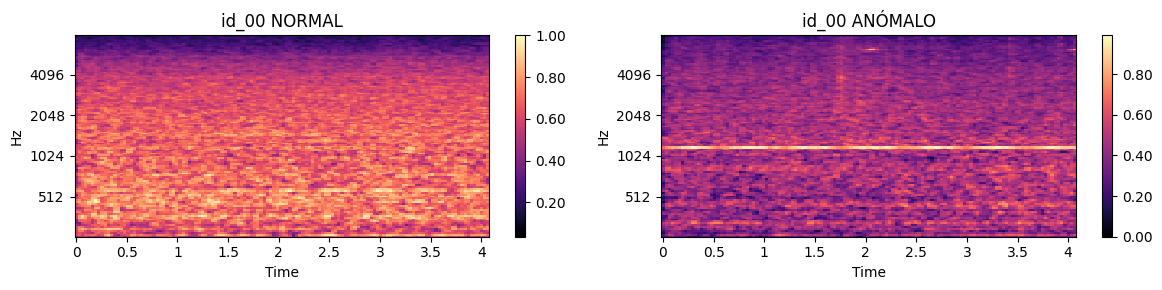

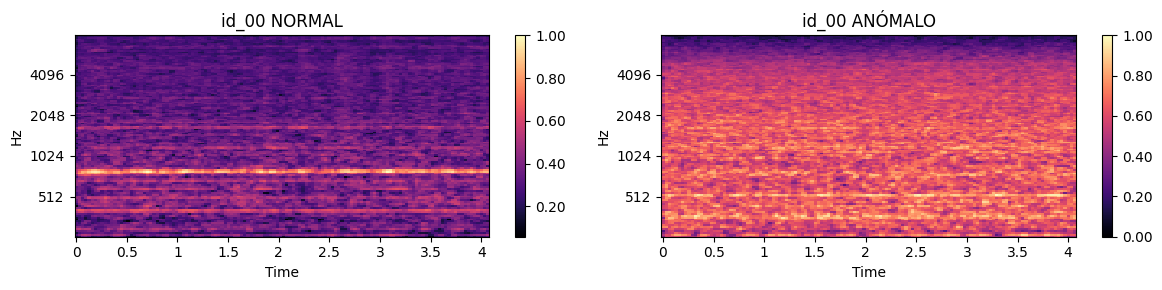


🛠️ Procesando máquina id_02


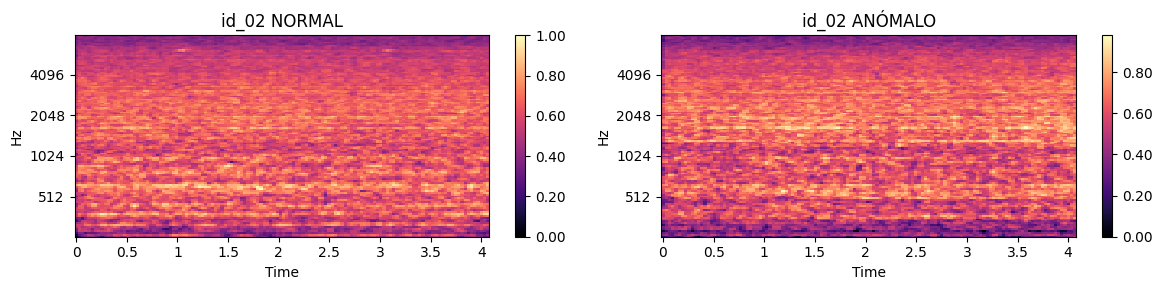

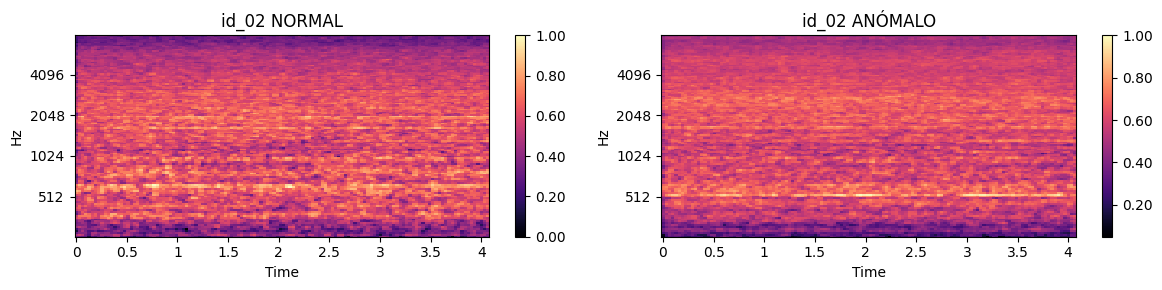


🛠️ Procesando máquina id_04


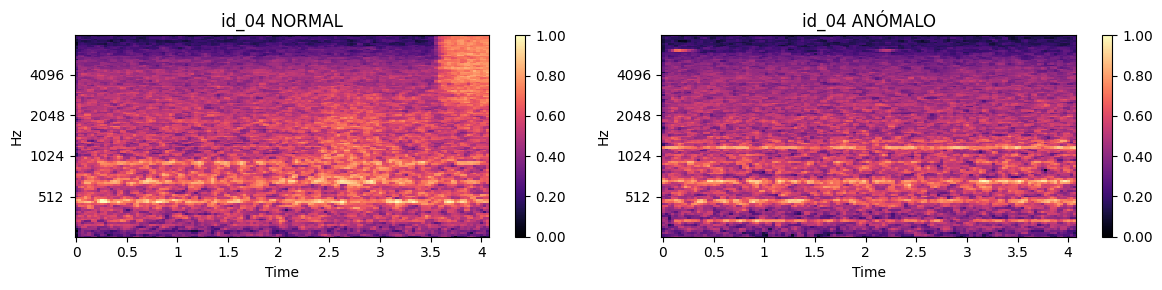

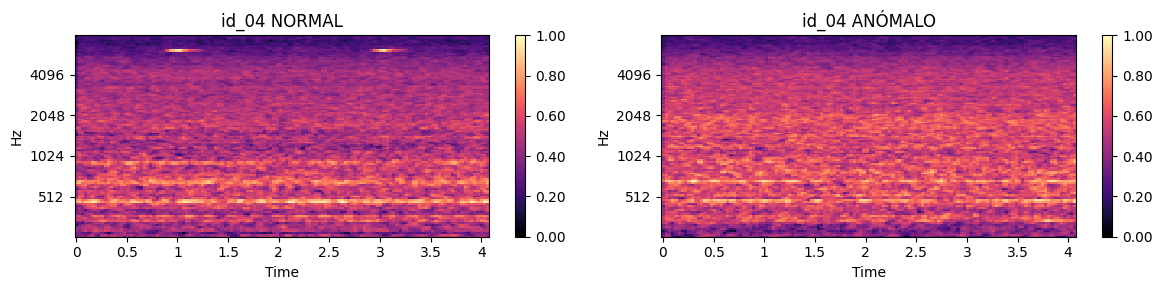


🛠️ Procesando máquina id_06


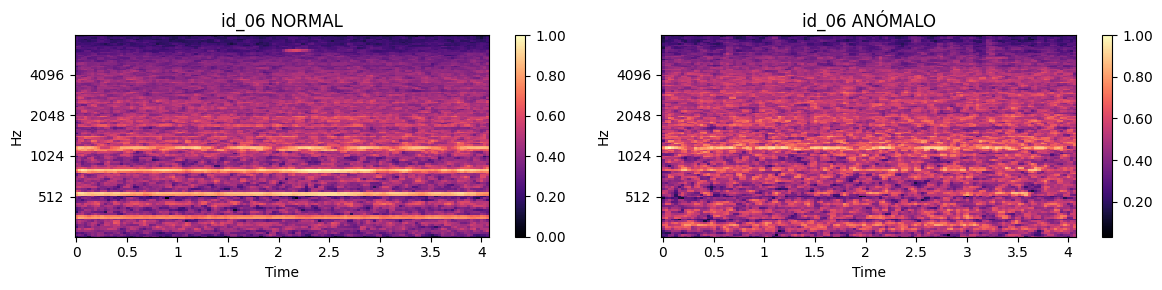

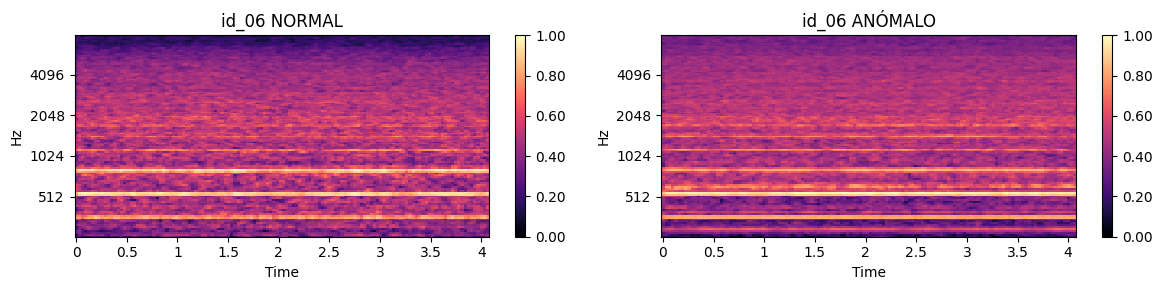


🛠️ Procesando máquina id_08


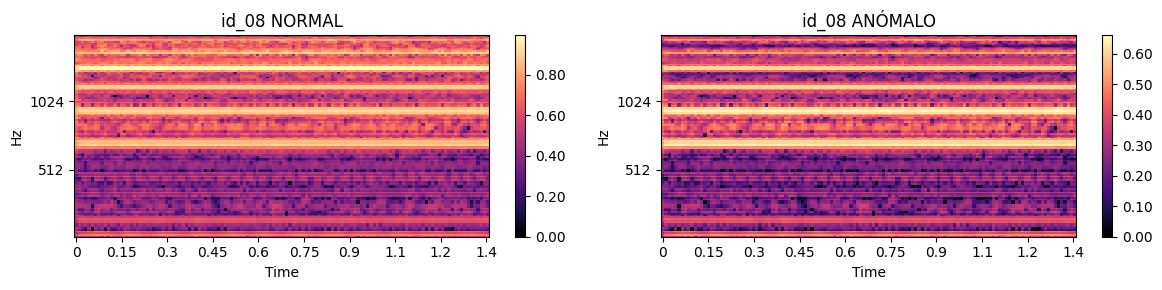

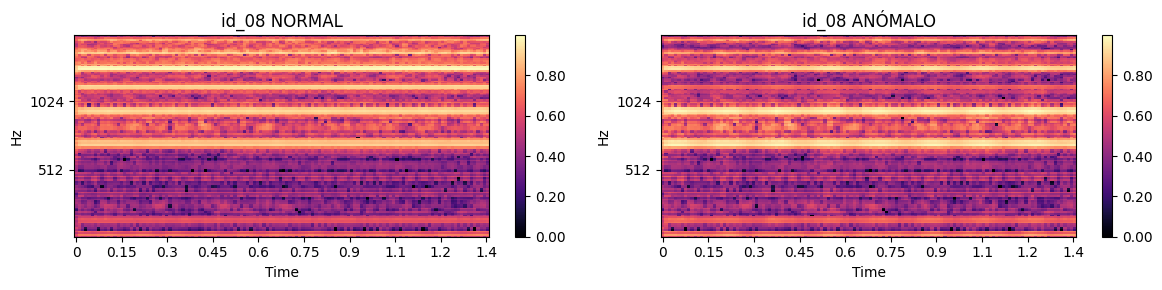

In [7]:
# === CONFIGURACIÓN INICIAL ===

# Ruta a la carpeta que contiene los audios de las máquinas (en este caso, ventiladores)
dataset_path = "/kaggle/input/mimii-fan-dataset2/fan"  # Puede cambiarse por otra ruta

# Cuántos pares de grabaciones (una normal y una anómala) queremos mostrar por cada máquina
files_per_type = 2


# === FUNCIONES AUXILIARES ===

def group_by_machine(paths):
    """
    Agrupa los archivos de audio según la máquina a la que pertenecen.

    Por ejemplo, todos los archivos que pertenecen a la máquina 'id_00' se colocan juntos.
    """
    grouped = {}
    for path in paths:
        machine_id = path.split("/")[-3]  # Extrae el ID de la máquina desde la ruta
        grouped.setdefault(machine_id, []).append(path)
    return grouped


def convert_audiofile_to_first_spectrogram(audio_path):
    """
    Toma un archivo de audio, lo divide en fragmentos y genera un espectrograma del primero que encuentra.

    Devuelve:
    - Una imagen del espectro de frecuencias del primer fragmento.
    - La frecuencia de muestreo original del audio.
    """
    machine_id = audio_path.split("/")[-3]  # Identifica a qué máquina pertenece el audio
    mic_type = get_mic_type_from_machine_id(machine_id)  # Determina el tipo de micrófono
    fmax = get_fmax_by_mic_type(mic_type)  # Ajusta el rango de frecuencias según el micrófono

    segments, sr = split_audio_into_segments(audio_path)  # Divide el audio en partes
    if len(segments) == 0:
        return None, sr  # Si no hay fragmentos válidos, se descarta

    version = segments[0]  # Se usa el primer fragmento, sin modificaciones
    melspec = convert_to_melspectrogram(version, sr, fmax=fmax)  # Se convierte en espectrograma
    normalized = normalize_minmax(melspec)  # Se normaliza para que los valores estén entre 0 y 1
    resized = resize_spectrogram(normalized)  # Se ajusta el tamaño de la imagen
    return resized, sr


# === RECOPILAR Y ORGANIZAR LOS ARCHIVOS DE AUDIO ===

# Se obtienen todas las rutas a archivos "normales" y "anómalos" dentro del dataset
normal_paths = get_audio_filepaths(dataset_path, "normal")
abnormal_paths = get_audio_filepaths(dataset_path, "abnormal")

# Agrupa los archivos por máquina para facilitar el análisis comparativo
normal_by_machine = group_by_machine(normal_paths)
abnormal_by_machine = group_by_machine(abnormal_paths)


# === MOSTRAR ESPECTROGRAMAS COMPARATIVOS POR MÁQUINA ===

# Recorre todas las máquinas que tienen tanto audios normales como anómalos
for machine_id in sorted(set(normal_by_machine) & set(abnormal_by_machine)):
    print(f"\n🛠️ Procesando máquina {machine_id}")

    # Obtiene las listas de archivos para esta máquina
    normal_candidates = normal_by_machine[machine_id]
    abnormal_candidates = abnormal_by_machine[machine_id]

    shown_pairs = 0
    normal_idx = 0
    abnormal_idx = 0

    # Muestra pares de espectrogramas (uno normal y uno anómalo) hasta alcanzar el número deseado
    while shown_pairs < files_per_type and normal_idx < len(normal_candidates) and abnormal_idx < len(abnormal_candidates):
        normal_file = normal_candidates[normal_idx]
        abnormal_file = abnormal_candidates[abnormal_idx]

        # Convierte los audios en espectrogramas para visualización
        normal_spec, sr_n = convert_audiofile_to_first_spectrogram(normal_file)
        abnormal_spec, sr_a = convert_audiofile_to_first_spectrogram(abnormal_file)

        # Si ambos espectrogramas se generaron correctamente, se visualizan juntos
        if normal_spec is not None and abnormal_spec is not None:
            fmax = get_fmax_by_mic_type(get_mic_type_from_machine_id(machine_id))
            display_spectrograms(
                spec1=normal_spec,
                spec2=abnormal_spec,
                sr=sr_n,
                fmin=20,
                fmax=fmax,
                title1=f"{machine_id} NORMAL",
                title2=f"{machine_id} ANÓMALO",
                orientation='horizontal'
            )
            shown_pairs += 1  # Contamos este par como mostrado

        # Avanzamos al siguiente archivo de cada tipo
        normal_idx += 1
        abnormal_idx += 1


## 📂 Generación De Los Conjuntos De Datos

Esta sección tiene como objetivo construir los conjuntos de entrenamiento, validación y test a partir de los archivos de audio del dataset. El proceso se realiza de forma controlada y reproducible, teniendo en cuenta tanto la separación temporal como el equilibrio entre clases. Las etapas principales son:

1. **Carga de rutas de audio**: Se obtienen las rutas de todos los archivos `.wav` del dataset, diferenciando entre grabaciones normales y anómalas.

2. **División de los datos normales**: Las grabaciones normales se dividen en dos subconjuntos: un 80% para entrenamiento y un 20% para prueba. Posteriormente, el 10% del conjunto de entrenamiento se reserva para validación.

3. **Preprocesamiento**: Cada archivo de audio se transforma en uno o más espectrogramas siguiendo el pipeline definido previamente. Además, se asocia cada espectrograma al identificador de la máquina correspondiente.

4. **Codificación de IDs de máquina**: Los identificadores de máquina (por ejemplo, `id_08`) se convierten en valores numéricos, necesarios para el entrenamiento de modelos que usan esta información como entrada adicional.

5. **Filtrado de datos anómalos**: Se procesan también los audios con fallos. Si un espectrograma anómalo pertenece a una máquina que no estuvo presente en el entrenamiento, se descarta.

6. **Construcción del conjunto de test**: Se combinan los espectrogramas normales y anómalos según una estrategia seleccionada:
   - **Realista**: baja proporción de fallos (10%),
   - **Balanceado**: igual número de muestras normales y anómalas,
   - **Estresado**: incluye todos los fallos disponibles.

7. **Mezcla y guardado**: Finalmente, los conjuntos se mezclan aleatoriamente y se guardan en disco en formato `.npy`, listos para usarse en el entrenamiento y la evaluación del modelo.

Este enfoque permite mantener un control preciso sobre la distribución de datos y simular distintos escenarios de prueba, lo que es fundamental para evaluar correctamente el rendimiento del sistema de detección.


In [8]:
from collections import Counter

# === CONFIGURACIÓN ===

# Ruta al dataset
base_file_path = "/kaggle/input/mimii-fan-dataset2/fan"

# === CARGA DE DATOS ===

# Se obtienen todas las rutas de archivos de audio normales y anómalos de todas las máquinas
normal_audio_filepaths = get_audio_filepaths(base_file_path, "normal")
abnormal_audio_filepaths = get_audio_filepaths(base_file_path, "abnormal")

# === DIVISIÓN ENTRE ENTRENAMIENTO Y TEST ===

# Se separan las grabaciones normales en 80% para entrenar y 20% para probar
normal_train_paths, normal_test_paths = train_test_split(
    normal_audio_filepaths, test_size=0.2, random_state=42
)

# === PREPROCESAMIENTO DE AUDIOS NORMALES (ENTRENAMIENTO) ===

print("Procesando espectrogramas normales (train)...")

# Convierte los audios en imágenes espectrales (espectrogramas) y recoge el ID de máquina de cada uno
normal_train_spectrograms, ids_train = process_audio_files_to_spectrograms(normal_train_paths)

# Asegura que las imágenes tengan la dimensión adicional requerida por los modelos (por canal)
normal_train_spectrograms = normal_train_spectrograms[..., np.newaxis]

# === CODIFICACIÓN DE IDENTIFICADORES DE MÁQUINAS ===

# Convierte los nombres de máquinas (por ejemplo, 'id_08') a números (0, 1, 2, etc.)
def encode_machine_ids(machine_ids):
    unique_ids = sorted(list(set(machine_ids)))
    id_to_int = {mid: i for i, mid in enumerate(unique_ids)}
    return np.array([id_to_int[mid] for mid in machine_ids]), id_to_int

machine_ids_train_encoded, id_to_int = encode_machine_ids(ids_train)

# === INFORMACIÓN DEL ENTRENAMIENTO ===

# Muestra cuántos espectrogramas hay para cada máquina en el conjunto de entrenamiento
counts_per_machine_train = Counter(ids_train)
print("\nEspectrogramas de entrenamiento por máquina:")
for machine_id in sorted(counts_per_machine_train):
    count = counts_per_machine_train[machine_id]
    print(f" - {machine_id}: {count} espectrogramas")

# Muestra qué código numérico corresponde a cada máquina
print("\nCodificación de machine_ids:")
for mid, code in id_to_int.items():
    print(f" - {mid}: {code}")

# === DIVISIÓN EN ENTRENAMIENTO Y VALIDACIÓN ===

# Separamos una parte del conjunto de entrenamiento para validación (10%)
X_train, X_val, ids_train_enc, ids_val_enc = train_test_split(
    normal_train_spectrograms, machine_ids_train_encoded, test_size=0.1, random_state=42
)

# === PREPROCESAMIENTO DE AUDIOS NORMALES (TEST) ===

print("\nProcesando espectrogramas normales (test)...")
normal_test_spectrograms, normal_ids = process_audio_files_to_spectrograms(normal_test_paths)
normal_test_spectrograms = normal_test_spectrograms[..., np.newaxis]

# Convertimos los IDs de las máquinas del test a números (usando solo los conocidos del entrenamiento)
normal_ids_encoded = np.array([id_to_int[mid] for mid in normal_ids if mid in id_to_int])

# === PREPROCESAMIENTO DE AUDIOS ANÓMALOS ===

print("\nProcesando espectrogramas anómalos...")
abnormal_spectrograms, abnormal_ids = process_audio_files_to_spectrograms(abnormal_audio_filepaths)
abnormal_spectrograms = abnormal_spectrograms[..., np.newaxis]

# Se descartan los espectrogramas de máquinas desconocidas (que no estaban en el entrenamiento)
abnormal_filtered = [(spec, mid) for spec, mid in zip(abnormal_spectrograms, abnormal_ids) if mid in id_to_int]
abnormal_spectrograms_filtered = np.array([x[0] for x in abnormal_filtered])
abnormal_ids_encoded = np.array([id_to_int[x[1]] for x in abnormal_filtered])

# === DEFINICIÓN DE ESTRATEGIA PARA EL CONJUNTO DE TEST ===

# Aquí puedes elegir cómo se construye el conjunto de test:
# - 'realista': pocos fallos, como ocurre en la realidad
# - 'balanceado': mismo número de ejemplos normales y anómalos
# - 'estresado': todos los fallos posibles
test_strategy = "balanceado"

# Se determinan qué máquinas tienen datos suficientes en ambos tipos
machine_ids_present = sorted(list(set(normal_ids_encoded) & set(abnormal_ids_encoded)))

# Inicializamos las listas del conjunto de prueba
X_test = []
y_test = []
machine_ids_test_encoded = []

# Recorremos cada máquina para construir sus ejemplos de test
for machine_id in machine_ids_present:
    # Seleccionamos sus espectrogramas normales y anómalos
    normal_specs = [spec for spec, mid in zip(normal_test_spectrograms, normal_ids_encoded) if mid == machine_id]
    abnormal_specs = [spec for spec, mid in zip(abnormal_spectrograms_filtered, abnormal_ids_encoded) if mid == machine_id]

    # Si una máquina no tiene suficientes datos, se omite
    if len(normal_specs) == 0 or len(abnormal_specs) == 0:
        print(f"Máquina {machine_id} no tiene suficientes datos para test. Será omitida.")
        continue

    # Dependiendo de la estrategia, elegimos cuántos ejemplos tomar
    if test_strategy == "realista":
        n_anomalies = max(1, int(len(normal_specs) * 0.1))  # solo un 10% de fallos
    elif test_strategy == "balanceado":
        n_anomalies = min(len(normal_specs), len(abnormal_specs))  # mismos normales y anómalos
    elif test_strategy == "estresado":
        n_anomalies = len(abnormal_specs)  # todos los fallos disponibles
    else:
        raise ValueError("Estrategia no válida. Usa: 'realista', 'balanceado' o 'estresado'.")

    # Se seleccionan los ejemplos
    selected_normals = normal_specs[:n_anomalies]
    selected_abnormals = abnormal_specs[:n_anomalies]

    # Se agregan al conjunto de test con sus respectivas etiquetas (0 = normal, 1 = fallo)
    X_test.extend(selected_normals)
    y_test.extend([0] * len(selected_normals))
    machine_ids_test_encoded.extend([machine_id] * len(selected_normals))

    X_test.extend(selected_abnormals)
    y_test.extend([1] * len(selected_abnormals))
    machine_ids_test_encoded.extend([machine_id] * len(selected_abnormals))

# === MEZCLA FINAL DEL CONJUNTO DE TEST ===

# Se mezcla aleatoriamente el conjunto de test para que las muestras estén desordenadas
X_test, y_test, machine_ids_test_encoded = shuffle(
    np.array(X_test), np.array(y_test), np.array(machine_ids_test_encoded), random_state=42
)

# === GUARDAR LOS CONJUNTOS EN ARCHIVOS ===

np.save("/kaggle/working/X_train.npy", X_train)
np.save("/kaggle/working/X_val.npy", X_val)
np.save("/kaggle/working/X_test.npy", X_test)
np.save("/kaggle/working/y_test.npy", y_test)
np.save("/kaggle/working/machine_ids_train.npy", ids_train_enc)
np.save("/kaggle/working/machine_ids_val.npy", ids_val_enc)
np.save("/kaggle/working/machine_ids_test.npy", machine_ids_test_encoded)

# === CONFIRMACIÓN DE LOS RESULTADOS ===

print("\nConjuntos generados y guardados.")
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

# Muestra cuántos ejemplos de test hay por cada máquina (con nombres legibles)
print("\nDistribución de machine_ids en test:")
inv_id_to_int = {v: k for k, v in id_to_int.items()}
test_counts = Counter(machine_ids_test_encoded)
for mid_enc, count in sorted(test_counts.items()):
    print(f" - {inv_id_to_int[mid_enc]} (id {mid_enc}): {count} muestras")


Procesando espectrogramas normales (train)...
Processed 1/3356 files. Total spectrograms: 4
Processed 501/3356 files. Total spectrograms: 2004
Processed 1001/3356 files. Total spectrograms: 4004
Processed 1501/3356 files. Total spectrograms: 6004
Processed 2001/3356 files. Total spectrograms: 8004
Processed 2501/3356 files. Total spectrograms: 10004
Processed 3001/3356 files. Total spectrograms: 12004
Processed 3356/3356 files. Total spectrograms: 13424

Espectrogramas de entrenamiento por máquina:
 - id_00: 3148 espectrogramas
 - id_02: 3264 espectrogramas
 - id_04: 3372 espectrogramas
 - id_06: 3280 espectrogramas
 - id_08: 360 espectrogramas

Codificación de machine_ids:
 - id_00: 0
 - id_02: 1
 - id_04: 2
 - id_06: 3
 - id_08: 4

Procesando espectrogramas normales (test)...
Processed 1/839 files. Total spectrograms: 4
Processed 501/839 files. Total spectrograms: 2004
Processed 839/839 files. Total spectrograms: 3356

Procesando espectrogramas anómalos...
Processed 1/1595 files. Tot

## 🧠 Modelo

En esta sección se define y entrena un **autoencoder convolucional condicionado** para modelar el comportamiento acústico normal de distintas máquinas industriales. El objetivo del modelo es aprender a reconstruir con precisión los sonidos normales, de forma que cualquier desviación significativa en la reconstrucción pueda interpretarse como una posible anomalía.

Este tipo de enfoque es especialmente útil en entornos donde los datos de fallos son escasos o muy variados, ya que permite entrenar el sistema únicamente con ejemplos normales.

#### ¿Por qué un autoencoder condicionado?

El sistema propuesto debe analizar el sonido de **múltiples máquinas** con características distintas (estructura, potencia, nivel de ruido, etc.). Por eso, el modelo no solo recibe el espectrograma del sonido como entrada, sino también un **identificador numérico de la máquina** (`machine_id`). Este identificador se convierte internamente en un vector (embedding) que permite al modelo **adaptar su reconstrucción al tipo de máquina** que está analizando.

Este enfoque tiene varias ventajas:

- Permite **entrenar un único modelo** para todas las máquinas, en lugar de uno por cada máquina.
- Mejora la **capacidad del modelo para generalizar** a distintas configuraciones.
- Conserva la eficiencia en despliegues en entornos con recursos limitados (como Raspberry Pi).

#### Arquitectura del modelo

El modelo tiene dos componentes principales:

1. **Encoder**: comprime el espectrograma y el identificador de máquina en un vector compacto (embedding). Esta parte extrae los patrones relevantes del sonido.
2. **Decoder**: a partir de ese vector, intenta reconstruir el espectrograma original. Cuanto mejor se reconstruya, más "normal" se considera el sonido.

La arquitectura utiliza **capas convolucionales** para capturar patrones locales en los espectrogramas, seguidas de operaciones de reducción de dimensión (`MaxPooling` y `GlobalAveragePooling`). La información del `machine_id` se introduce mediante una capa de embedding y se concatena al vector comprimido antes de la reconstrucción.

#### Entrenamiento

- El modelo se entrena utilizando únicamente **sonidos normales**.
- La función de pérdida es el **error cuadrático medio (MSE)** entre el espectrograma original y el reconstruido.
- Se aplica **early stopping** para evitar sobreentrenamiento, deteniendo el entrenamiento si no hay mejora en el conjunto de validación durante varias épocas.

Una vez entrenado, el encoder se utiliza para extraer vectores (embeddings) de nuevos sonidos. La distancia entre estos embeddings y los correspondientes a sonidos normales permite detectar posibles fallos de forma no supervisada.


In [9]:
def build_conditional_autoencoder(input_shape=(128, 128, 1), embedding_dim=32, num_ids=4, id_embedding_dim=8):
    """
    Crea un modelo de autoencoder que toma como entrada:
    - una imagen (espectrograma del sonido de una máquina),
    - y un identificador numérico que representa la máquina específica.

    El objetivo del modelo es aprender a reconstruir el sonido original,
    teniendo en cuenta las características únicas de cada máquina.
    """

    # === ENTRADAS DEL MODELO ===

    # Entrada principal: una imagen espectral de 128x128 con un solo canal (blanco y negro)
    spec_input = tf.keras.Input(shape=input_shape, name="spectrogram")

    # Entrada secundaria: un número que representa el ID de la máquina
    id_input = tf.keras.Input(shape=(1,), name="machine_id")


    # === REPRESENTACIÓN NUMÉRICA DEL ID DE LA MÁQUINA ===

    # El ID se transforma en una pequeña secuencia de números que el modelo puede entender mejor.
    # Esto permite que el modelo aprenda diferencias específicas entre máquinas.
    id_emb_layer = layers.Embedding(input_dim=num_ids, output_dim=id_embedding_dim, name="id_embedding")
    id_emb = id_emb_layer(id_input)         # convierte el ID a una representación aprendida
    id_emb = layers.Flatten()(id_emb)       # elimina dimensiones innecesarias


    # === BLOQUE ENCODER (compresión del espectrograma) ===

    # El encoder reduce la imagen a una representación más pequeña y compacta,
    # extrayendo patrones importantes del sonido.

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(spec_input)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)  # convierte a vector resumen (no imagen)

    # Combina la información del espectrograma con la del identificador de la máquina
    merged = layers.Concatenate()([x, id_emb])

    # Capa final del encoder: crea un "resumen numérico" del sonido y la máquina
    embedding_output = layers.Dense(embedding_dim, name="embedding")(merged)


    # === BLOQUE DECODER (reconstrucción del espectrograma) ===

    # A partir del resumen, intenta reconstruir la imagen original del espectrograma

    x = layers.Dense(16 * 16 * 64, activation='relu')(embedding_output)
    x = layers.Reshape((16, 16, 64))(x)

    x = layers.UpSampling2D(2)(x)  # duplicar tamaño a 32x32
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

    x = layers.UpSampling2D(2)(x)  # a 64x64
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

    x = layers.UpSampling2D(2)(x)  # a 128x128
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

    # Capa de salida: reconstruye la imagen final con un solo canal, valores entre 0 y 1
    output = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)


    # === DEFINICIÓN Y COMPILACIÓN DE LOS MODELOS ===

    # Modelo completo: de entrada a reconstrucción
    autoencoder = tf.keras.Model(inputs=[spec_input, id_input], outputs=output)

    # Modelo parcial: solo el encoder, útil para extraer representaciones del sonido
    encoder = tf.keras.Model(inputs=[spec_input, id_input], outputs=embedding_output)

    # Se entrena el modelo usando el error cuadrático medio entre original y reconstruido
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder


In [10]:
# === DEFINICIÓN DEL MODELO CONDICIONADO ===

# Se crea el modelo de autoencoder que aprenderá a reconstruir sonidos (espectrogramas),
# teniendo en cuenta también el identificador de cada máquina.

autoencoder, encoder = build_conditional_autoencoder(
    input_shape=(128, 128, 1),     # Tamaño de las imágenes de entrada
    embedding_dim=32,             # Tamaño del vector resumen que se extrae del sonido
    num_ids=len(id_to_int),       # Número total de máquinas distintas
    id_embedding_dim=8            # Tamaño del vector que representa cada ID de máquina
)

# === COMPILACIÓN DEL MODELO ===

# Se configura el modelo para aprender, usando:
# - optimizador 'adam' (eficiente y adaptativo)
# - función de error 'mse' (error cuadrático medio)
# - métrica adicional 'mae' (error absoluto medio)

autoencoder.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# === DEFINICIÓN DE PARADA TEMPRANA ===

# Se detiene el entrenamiento si el modelo deja de mejorar durante 5 épocas seguidas
# y se restauran los mejores pesos encontrados durante el proceso.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# === ENTRENAMIENTO DEL MODELO ===

# Se entrena el modelo durante un máximo de 50 épocas.
# Como entrada se usa tanto el espectrograma como el identificador de máquina.
# El modelo intenta reconstruir la imagen original a partir de esa información.

history = autoencoder.fit(
    [X_train, ids_train_enc],    # Entradas: espectrograma + ID
    X_train,                     # Salida esperada: el mismo espectrograma
    validation_data=([X_val, ids_val_enc], X_val),  # Validación durante el entrenamiento
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],      # Aplicar parada temprana si no mejora
    verbose=2                    # Mostrar resumen por época
)


I0000 00:00:1748795710.766461      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748795710.767180      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1748795723.400075     130 service.cc:148] XLA service 0x7bdfb404a110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748795723.401406     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748795723.401423     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748795723.944192     130 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748795736.062670     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 - 54s - 287ms/step - loss: 0.0122 - mae: 0.0816 - val_loss: 0.0073 - val_mae: 0.0624
Epoch 2/50
189/189 - 20s - 106ms/step - loss: 0.0063 - mae: 0.0579 - val_loss: 0.0058 - val_mae: 0.0552
Epoch 3/50
189/189 - 21s - 109ms/step - loss: 0.0057 - mae: 0.0547 - val_loss: 0.0056 - val_mae: 0.0542
Epoch 4/50
189/189 - 21s - 113ms/step - loss: 0.0055 - mae: 0.0536 - val_loss: 0.0053 - val_mae: 0.0532
Epoch 5/50
189/189 - 22s - 117ms/step - loss: 0.0053 - mae: 0.0527 - val_loss: 0.0051 - val_mae: 0.0521
Epoch 6/50
189/189 - 22s - 115ms/step - loss: 0.0052 - mae: 0.0521 - val_loss: 0.0050 - val_mae: 0.0515
Epoch 7/50
189/189 - 21s - 113ms/step - loss: 0.0050 - mae: 0.0515 - val_loss: 0.0050 - val_mae: 0.0516
Epoch 8/50
189/189 - 21s - 114ms/step - loss: 0.0049 - mae: 0.0511 - val_loss: 0.0048 - val_mae: 0.0506
Epoch 9/50
189/189 - 22s - 115ms/step - loss: 0.0049 - mae: 0.0508 - val_loss: 0.0048 - val_mae: 0.0504
Epoch 10/50
189/189 - 22s - 115ms/step - loss: 0.0048 - mae: 0.0506 - val_l

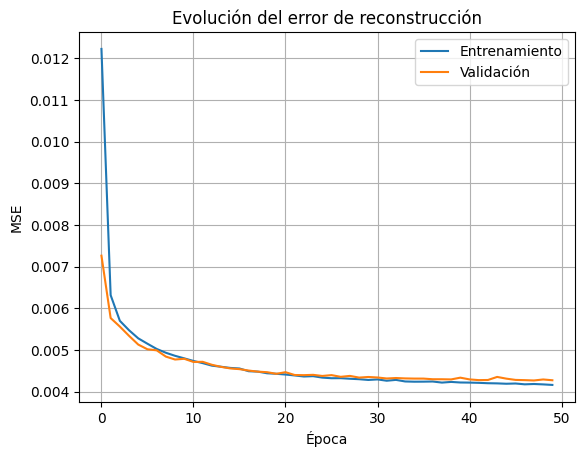

In [11]:
# === VISUALIZACIÓN DEL ENTRENAMIENTO ===

# Se dibuja una gráfica para ver cómo evoluciona el error durante el entrenamiento
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Evolución del error de reconstrucción")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
🔍 AUC (ROC): 0.8402  --> Mide qué tan bien el sistema separa sonidos normales de fallos.


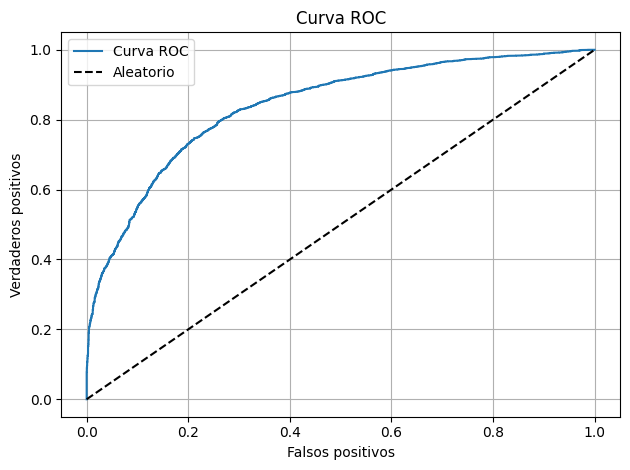

📏 Umbral de decisión: 0.3150


/tmp/ipykernel_35/3856602494.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


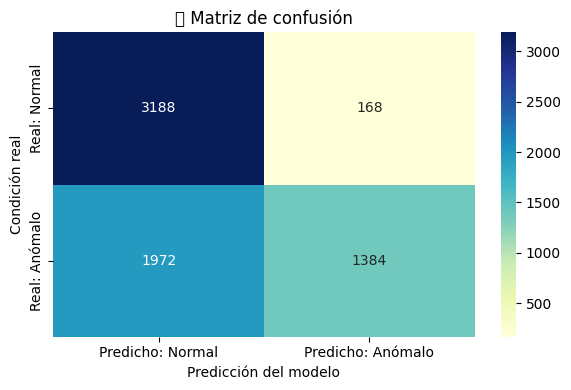

📋 Informe de clasificación:
              precision    recall  f1-score   support

      Normal       0.62      0.95      0.75      3356
     Anómalo       0.89      0.41      0.56      3356

    accuracy                           0.68      6712
   macro avg       0.75      0.68      0.66      6712
weighted avg       0.75      0.68      0.66      6712



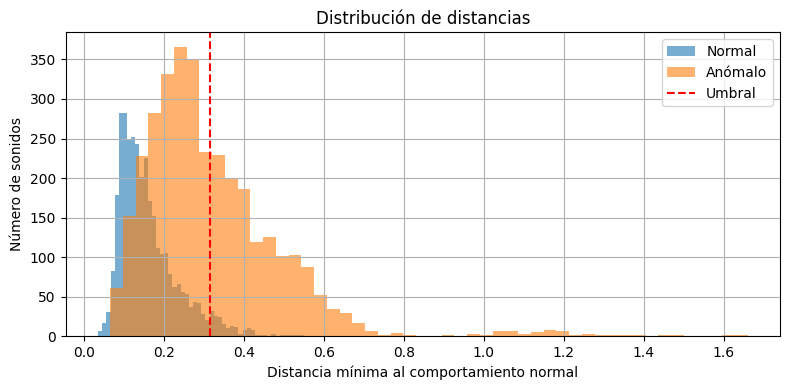

In [14]:
# === 1. GENERACIÓN DE "HUELLAS SONORAS" (EMBEDDINGS) ===

# El modelo transforma cada espectrograma en un vector resumen numérico (embedding),
# que representa cómo "suena" ese fragmento. Lo hace tanto para entrenamiento como para test.

emb_train = encoder.predict([X_train, ids_train_enc], batch_size=64)
emb_test = encoder.predict([X_test, machine_ids_test_encoded], batch_size=64)

# === 2. CÁLCULO DE DISTANCIA MÍNIMA ENTRE EMBEDDINGS ===

# Esta función compara cada sonido del test con los sonidos normales de la misma máquina.
# Cuanto mayor es la distancia, más raro es ese sonido respecto a lo que el modelo ha aprendido como "normal".

def compute_min_distances_by_machine(emb_test, ids_test, emb_train, ids_train):
    distances = []
    for e, mid in zip(emb_test, ids_test):
        train_subset = emb_train[ids_train == mid]  # Solo embeddings de la misma máquina
        dists = np.linalg.norm(train_subset - e, axis=1)  # Distancia euclídea
        distances.append(np.min(dists))  # Nos quedamos con la distancia más parecida
    return np.array(distances)

distances = compute_min_distances_by_machine(
    emb_test, machine_ids_test_encoded, emb_train, ids_train_enc
)

# === 3. EVALUACIÓN DEL MODELO USANDO DISTANCIAS ===

def evaluate_embedding_model(distances, y_test):
    # --- AUC (Area bajo la curva ROC) ---
    auc = roc_auc_score(y_test, distances)
    print(f"🔍 AUC (ROC): {auc:.4f}  --> Mide qué tan bien el sistema separa sonidos normales de fallos.")

    # --- Curva ROC ---
    fpr, tpr, _ = roc_curve(y_test, distances)
    plt.figure()
    plt.plot(fpr, tpr, label="Curva ROC")
    plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio")
    plt.title("Curva ROC")
    plt.xlabel("Falsos positivos")
    plt.ylabel("Verdaderos positivos")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Definición de umbral ---
    # Se usa como umbral el valor que deja fuera al 5% más alejado de los sonidos normales
    threshold = np.percentile(distances[y_test == 0], 95)
    print(f"📏 Umbral de decisión: {threshold:.4f}")

    # Clasificación: si la distancia es mayor que el umbral → anómalo
    y_pred = (distances > threshold).astype(int)

    # --- Matriz de confusión visual ---
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Real: Normal", "Real: Anómalo"],
        columns=["Predicho: Normal", "Predicho: Anómalo"]
    )

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("📊 Matriz de confusión")
    plt.ylabel("Condición real")
    plt.xlabel("Predicción del modelo")
    plt.tight_layout()
    plt.show()

    # --- Métricas detalladas ---
    print("📋 Informe de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Anómalo"]))

    # --- Visualización de la distribución de distancias ---
    plt.figure(figsize=(8, 4))
    plt.hist(distances[y_test == 0], bins=50, alpha=0.6, label="Normal")
    plt.hist(distances[y_test == 1], bins=50, alpha=0.6, label="Anómalo")
    plt.axvline(threshold, color='red', linestyle='--', label="Umbral")
    plt.legend()
    plt.grid()
    plt.title("Distribución de distancias")
    plt.xlabel("Distancia mínima al comportamiento normal")
    plt.ylabel("Número de sonidos")
    plt.tight_layout()
    plt.show()

# Ejecutamos la evaluación
evaluate_embedding_model(distances, y_test)

📐 AUC-ROC: 0.8402
✅ Mejor umbral (F1-score): 0.1768 - F1: 0.7783

📊 Métricas por clase:
              precision    recall  f1-score   support

      Normal       0.80      0.70      0.75      3356
     Anómalo       0.73      0.83      0.78      3356

    accuracy                           0.76      6712
   macro avg       0.77      0.76      0.76      6712
weighted avg       0.77      0.76      0.76      6712



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


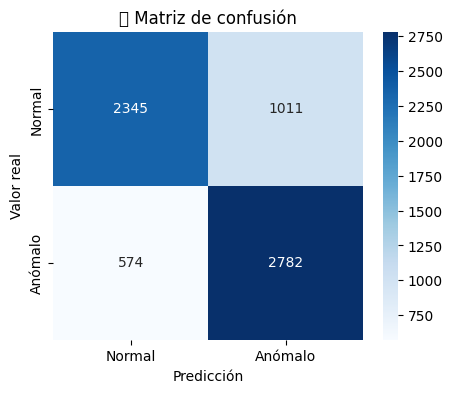

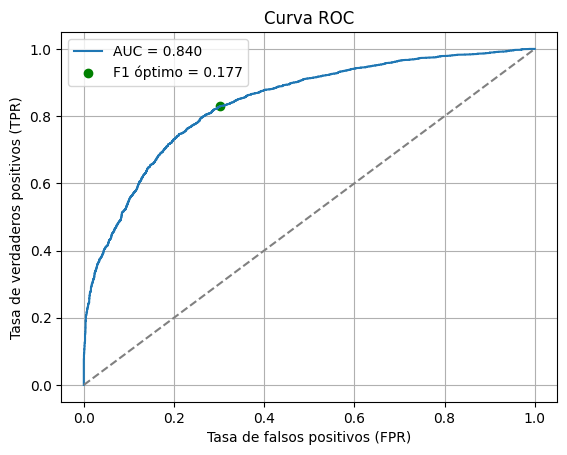

In [20]:
# Importamos las librerías necesarias
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # 🔥 Usamos seaborn para la matriz de confusión visual
import pandas as pd

# === 1. Calcular la curva ROC y el valor AUC ===
fpr, tpr, thresholds = roc_curve(y_test, distances)
auc = roc_auc_score(y_test, distances)
print(f"📐 AUC-ROC: {auc:.4f}")

# === 2. Buscar el mejor umbral según F1-score ===
f1_scores = []
for thresh in thresholds:
    y_pred = (distances > thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

best_idx_f1 = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_idx_f1]
print(f"✅ Mejor umbral (F1-score): {best_threshold_f1:.4f} - F1: {f1_scores[best_idx_f1]:.4f}")

# === 3. Predicciones finales con el mejor umbral ===
y_pred_best = (distances > best_threshold_f1).astype(int)

# === 4. Métricas detalladas por clase ===
print("\n📊 Métricas por clase:")
print(classification_report(y_test, y_pred_best, target_names=["Normal", "Anómalo"]))

# === 5. Matriz de confusión como heatmap ===
cm = confusion_matrix(y_test, y_pred_best)
labels = ["Normal", "Anómalo"]

# Creamos un DataFrame para mostrar etiquetas en filas y columnas
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Dibujamos el mapa de calor
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("🧮 Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# === 6. Curva ROC con el mejor punto F1 ===
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.scatter(fpr[best_idx_f1], tpr[best_idx_f1], c='green', label=f'F1 óptimo = {best_threshold_f1:.3f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()


In [22]:

import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import roc_curve, f1_score, classification_report

# === 1. EXPORTAR EL ENCODER A FORMATO TFLITE ===
print("📤 Exportando encoder...")

# Tomamos el encoder (modelo que convierte el espectrograma en embedding)
encoder_model = encoder  # Asegúrate de que esté definido

# Convertimos el modelo a formato TFLite para usarlo en Raspberry Pi
converter = tf.lite.TFLiteConverter.from_keras_model(encoder_model)
tflite_model = converter.convert()

# Guardamos el archivo resultante
with open("encoder.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ Guardado: encoder.tflite")


# === 2. GUARDAR LOS EMBEDDINGS DE ENTRENAMIENTO Y LOS MACHINE IDs ===
print("📤 Guardando embeddings y machine_ids de entrenamiento...")

# Guardamos los embeddings del set de entrenamiento y sus IDs codificados
np.save("emb_train.npy", emb_train)
np.save("ids_train.npy", ids_train_enc)
print("✅ Guardado: emb_train.npy, ids_train.npy")


# === 3. GUARDAR EL DICCIONARIO DE ID → NÚMERO ===
print("📤 Guardando diccionario de IDs (id_to_int)...")

# Este diccionario traduce los nombres de máquina a números internos
with open("id_to_int.pkl", "wb") as f:
    pickle.dump(id_to_int, f)
print("✅ Guardado: id_to_int.pkl")


# === 4. CALCULAR Y GUARDAR LOS MEJORES UMBRALES PARA CADA MÁQUINA ===
print("📊 Calculando umbrales óptimos por machine_id...")

# Creamos un DataFrame con etiquetas reales, distancias y el ID de la máquina
df_eval = pd.DataFrame({
    "y_true": y_test,  # Etiqueta real: 0 = normal, 1 = anómalo
    "score": distances,  # Distancia del embedding con respecto a los normales
    "machine_id": machine_ids_test_encoded  # ID numérico de la máquina
})

machine_metrics = []  # Aquí guardaremos métricas por máquina

# Recorremos cada máquina del test
for machine in df_eval["machine_id"].unique():
    df_machine = df_eval[df_eval["machine_id"] == machine]
    y_true = df_machine["y_true"]
    y_score = df_machine["score"]

    # Si solo hay una clase (todo normal o todo anómalo), se omite
    if y_true.nunique() < 2:
        continue

    # Calculamos curva ROC y F1-score para todos los umbrales
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    f1_scores = [f1_score(y_true, y_score > t) for t in thresholds]

    # Buscamos el umbral que maximiza el F1-score
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]

    # Guardamos el umbral óptimo para esta máquina
    machine_metrics.append({
        "machine_id": int(machine),
        "best_threshold": float(best_thresh)
    })

# Convertimos la lista a DataFrame y la ordenamos
df_machine_metrics = pd.DataFrame(machine_metrics).sort_values(by="machine_id")

# Guardamos como CSV por si se quiere revisar
df_machine_metrics.to_csv("thresholds_by_machine.csv", index=False)

# También lo guardamos como diccionario para usar directamente en inferencia
thresholds_by_machine = {
    row["machine_id"]: row["best_threshold"]
    for _, row in df_machine_metrics.iterrows()
}

with open("thresholds_by_machine.pkl", "wb") as f:
    pickle.dump(thresholds_by_machine, f)

print("✅ Guardado: thresholds_by_machine.pkl")


# === 5. MOSTRAR MÉTRICAS POR CLASE (NORMAL / ANÓMALO) PARA CADA MÁQUINA ===
print("\n📊 Métricas por clase (normal / anómalo) para cada máquina:\n")

for machine in sorted(df_eval["machine_id"].unique()):
    if machine not in thresholds_by_machine:
        continue  # Saltamos las máquinas sin umbral óptimo

    # Seleccionamos los datos de esta máquina
    df_machine = df_eval[df_eval["machine_id"] == machine]
    y_true = df_machine["y_true"]
    y_score = df_machine["score"]
    threshold = thresholds_by_machine[machine]

    # Clasificamos usando el umbral óptimo encontrado
    y_pred = (y_score > threshold).astype(int)

    # Mostramos métricas por clase
    print(f"🛠️  Máquina ID {machine} (umbral óptimo = {threshold:.4f}):")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anómalo"]))


📤 Exportando encoder...
Saved artifact at '/tmp/tmplniyjum2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='spectrogram'), TensorSpec(shape=(None, 1), dtype=tf.float32, name='machine_id')]
Output Type:
  TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)
Captures:
  136210430035728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210430046288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210430041488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210430041680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210430041104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210430038608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210430048208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210424057680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136210424065360: TensorSpec(shape=(), dtype=tf.resource, n

W0000 00:00:1748797740.008813      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748797740.008844      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748797740.015970      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


✅ Guardado: encoder.tflite
📤 Guardando embeddings y machine_ids de entrenamiento...
✅ Guardado: emb_train.npy, ids_train.npy
📤 Guardando diccionario de IDs (id_to_int)...
✅ Guardado: id_to_int.pkl
📊 Calculando umbrales óptimos por machine_id...
✅ Guardado: thresholds_by_machine.pkl

📊 Métricas por clase (normal / anómalo) para cada máquina:

🛠️  Máquina ID 0 (umbral óptimo = 0.1161):
              precision    recall  f1-score   support

      Normal       0.79      0.27      0.40       896
     Anómalo       0.56      0.93      0.70       896

    accuracy                           0.60      1792
   macro avg       0.67      0.60      0.55      1792
weighted avg       0.67      0.60      0.55      1792

🛠️  Máquina ID 1 (umbral óptimo = 0.1617):
              precision    recall  f1-score   support

      Normal       0.82      0.69      0.75       800
     Anómalo       0.73      0.84      0.79       800

    accuracy                           0.77      1600
   macro avg       0.78  